In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
sys.path.append('../')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
a = torch.tensor([4])
b = torch.tensor([5]).to(device)
a.to(b.device)*b

tensor([20], device='cuda:0')

###### Noise Scheduler

In [4]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((1 - self.alphas[t])/self.sqrt_one_minus_alpha_cum_prod[t]) * noise_pred
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

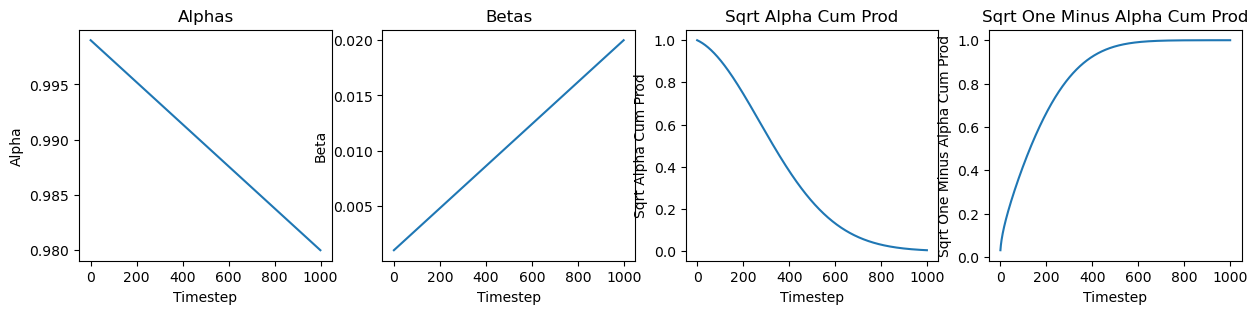

In [5]:
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')


torch.Size([1, 3, 128, 128])


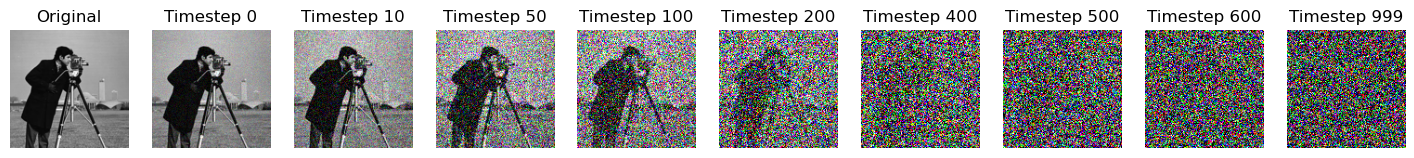

In [63]:
test_img = Image.open("../images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(18,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img, noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')

###### Model

In [6]:
import yaml
from src.model import Unet
config_path = "../config/default.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

##### Dataset and Dataloder

In [7]:
#make a custom dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
from tqdm.auto import tqdm

class Image_Dataset(Dataset):
    def __init__(self, path2data, transform=None, im_ext = 'png'):
        self.path2data = path2data
        self.transform = transform
        self.im_ext = im_ext
        self.data, self.labels = self.load_images(path2data)

    def load_images(self, path2data):
        import os
        import glob
        im = []
        labels = []

        for i in os.listdir(path2data):
            files = glob.glob(os.path.join(path2data, i, self.im_ext))
            for j in files:
                im.append(j)
                labels.append(i)
        return im, labels


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = Image.open(sample)

        if self.transform:
            sample = self.transform(sample)
        else:
            sample = transforms.ToTensor()(sample)
        
        sample = (2*sample) - 1    #normalizing the image between -1 and 1
        return sample, torch.tensor(int(label))

In [8]:
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=32, shuffle=True, num_workers=4)

In [9]:
for x,y in mnist_data:
    print(x.shape)
    print(y)
    break

torch.Size([1, 28, 28])
tensor(0)


##### Training Loop

In [10]:
model = Unet(config['model_params'])
model.to(device)
model.train()
num_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
num_timesteps = 1000

In [11]:
train_loss = []
for epoch_idx in range(num_epochs):
    losses = []
    init_loss = np.inf
    for im,_ in tqdm(mnist_dataloader):
        im = im.to(device)
        optimizer.zero_grad()
        noise = torch.randn_like(im).to(device) #sample noise
        t = torch.randint(0, num_timesteps, (im.shape[0],)) #sample timesteps
        t = t.to(device)

        noisy_im = scheduler.add_noise(im, noise, t)
        noise_pred = model(noisy_im, t)

        loss = criterion(noise_pred, im)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss.append(np.mean(losses))
    if train_loss[-1] < init_loss:
        torch.save(model.state_dict(), f'../model_weights/unet_best.pt')
        print('Model Saved at epoch: ', epoch_idx)
        init_loss = train_loss[-1]


  0%|          | 0/1875 [00:00<?, ?it/s]

- Check the device requirement. 
- Complete the sampling Part. 

In [23]:
import os
import glob
path2data = "../data/MNIST_data/train/images/"
labels = []
im = []
for i in os.listdir(path2data):
    files = glob.glob(os.path.join(path2data, i, '*.png'))
    for j in files:
        im.append(j)
        labels.append(i)


In [49]:
im.device

device(type='cuda', index=0)